# Ch. 1 ARMA Models
### Time Series are everywhere
- Science
- Technology
- Business
- Finance
- Policy

## Learning Objectives
- Structure of ARIMA Models
- How to fit ARIMA model
- How to Optimize ARIMA
- How to make forecasts
- How to calculate uncertainty in predictions

### To model a time series, the data must have Stationarity
- Trend Stationarity: trend is zero
- Variance is constant
- Autocorrelation is constant

### Is it stationary
Identifying whether a time series is stationary or non-stationary is very important. If it is stationary you can use ARMA models to predict the next values of the time series. If it is non-stationary then you cannot use ARMA models

### Train-test Split
- train on data earlier in time series, and cast/predict on data later in the time series
- split data at a given date

#### Candy Dataset

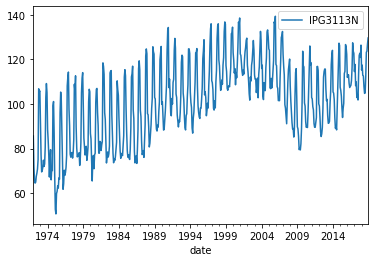

In [1]:
# Import modules
import matplotlib.pyplot as plt
import pandas as pd

# Load in the time series
candy = pd.read_csv('candy_production.csv', 
            index_col='date',
            parse_dates=True)

# Plot and show the time series on axis ax
fig, ax = plt.subplots()
candy.plot(ax=ax)
plt.show()

In this exercise you are going to take the candy production dataset and split it into a train and a test set. Like you understood in the video exercise, the reason to do this is so that you can test the quality of your model fit when you are done.

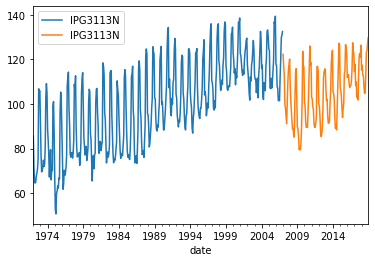

In [2]:
# Split the data into a train and test set
candy_train = candy.loc[:'2006']
candy_test = candy.loc['2007':]

# Create an axis
fig, ax = plt.subplots()

# Plot the train and test sets on the axis ax
candy_train.plot(ax=ax)
candy_test.plot(ax=ax)
plt.show()

## Making time series Stationary
- statistical tests for stationarity
- Making a dataset Stationary

### Augmented Dicky-Fuller test
- tests for trend non-stationarity
- Null hypothesis is the time series is non-stationary
- If p-value (index 1 of results) is greater than 0.05, the data is assumed to be non-stationary

### The value of plotting
- plotting time series can stop you making wrong assumptions that the adf test might miss

### making a time series stationary
- taking the difference is a very common way. Subtract the previous value from the current value. pandas .diff() method
- take the log np.log(df)
- take the sqrt np.sqrt(df)
- take the proportional change df.shift(1)/df

In [3]:
import pandas as pd
earthquake = pd.read_csv('earthquakes.csv', index_col='date', parse_dates=True).drop('Year', axis=1)

# Import augmented dicky-fuller test function
from statsmodels.tsa.stattools import adfuller

# Run test
result = adfuller(earthquake['earthquakes_per_year'])

# Print test statistic
print(result[0])

# Print p-value
print(result[1])

# Print critical values
print(result[4]) 

-3.183192251191782
0.02097842525600371
{'1%': -3.5003788874873405, '5%': -2.8921519665075235, '10%': -2.5830997960069446}


In [4]:
import pandas as pd
import numpy as np
amazon = pd.read_csv('amazon_close.csv', index_col='date', parse_dates=True)

# Calculate the first difference and drop the nans
amazon_diff = amazon.diff()
amazon_diff = amazon_diff.dropna()

# Run test and print
result_diff = adfuller(amazon_diff['close'])
print('Diff p-value: ',result_diff[1])

# Calculate log-return and drop nans
amazon_log = np.log(amazon)
amazon_log = amazon_log.dropna()

# Run test and print
result_log = adfuller(amazon_log['close'])
print('Log p-value: ',result_log[1])

Diff p-value:  2.331271725487306e-10
Log p-value:  0.8266466281503949


## Intro to AR, MA, and ARMA Models
### AR (Autoregressive) model
   - Regress the values of the time series against previous values of the same time series
   - Y(t) = A*Y(t-1) + E(t)
       - Y(t) = current value
       - Y(t-1) = previous value in th period
       - E(t) = Shock value = residuals = white noise, not related to E(t) of other values
   - AR(1) is using one lag = Order 1. 
   - AR(p) where p is used to represent the order

### MA (Moving Average) model
   - Regress the values of the time series against the previous shock values of the same time series
   - Y(t) = m* E(t-1) + E(t)
   - MA(1) is using one lag = Order 1. 
   - MA(q) where q is used to represent the order
   
### ARMA (Autoregressive Moving Average) model
- ARMA = AR + MA
- Time series is regressed on the previous values and the previous shock terms
- ARMA(1,1) = Y(t) = a*Y(t-1) + m*E(t-1) + E(t)
- ARMA(p, q):
    - p is order of AR part
    - q is order of MA part
    
##### Simulating an ARMA model

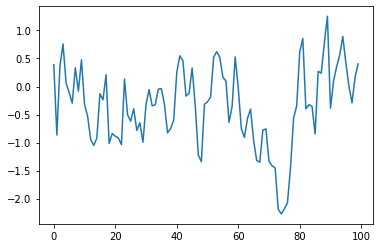

In [5]:
from statsmodels.tsa.arima_process import arma_generate_sample
# Create lists for coefficients
ar_coef = [1, -0.5]
ma_coef = [1, 0.2]

# Generate Data
y = arma_generate_sample(ar_coef, ma_coef, nsample=100, scale=0.5)

plt.plot(y)
plt.show()

# Ch. 2 Fitting Time Series Models

#### Fitting a model on the earthquake data

In [6]:
import pandas as pd
earthquake = pd.read_csv('earthquakes.csv', index_col='date', parse_dates=True).drop('Year', axis=1)

from statsmodels.tsa.arima_model import ARMA

# Instantiate the model
model = ARMA(earthquake, order=(3,1))

# Fit the model
results = model.fit()

# Print model fit summary
print(results.summary())

C:\Users\16084\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'


                               ARMA Model Results                               
Dep. Variable:     earthquakes_per_year   No. Observations:                   99
Model:                       ARMA(3, 1)   Log Likelihood                -315.673
Method:                         css-mle   S.D. of innovations              5.853
Date:                  Wed, 21 Apr 2021   AIC                            643.345
Time:                          19:59:10   BIC                            658.916
Sample:                      01-01-1900   HQIC                           649.645
                           - 01-01-1998                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         19.6452      1.929     10.183      0.000      15.864      23.426
ar.L1.earthquakes_per_year     0.5794      0.416      1.393      0.

## ARMAX Models
These are fit similarily to the ARMA models but have an external (exogenous) variable added that may have an effect on the time series. Adds a Linear Regression component to the model. 
- If assessing personal productivity over time, adding an exog variable of sleep may assist in predicting productivity.
- Y(t) = x*Z(t-1) + a*Y(t-1) + m*E(t-1) + E(t) where Z is the exog variable and x is the coefficient
- variable is passes in the exog argument of the ARMA model

## Forecasting
### Predicting the next value
- current value is predicted using the previous value in the ARMA equation

Use the SARIMAX class from stats models. It can do all that the ARMA class can do as well as more
- from statsmodels.tsa.statespace.sarimax import SARIMAX
- to do just an arma(p,q) model
    - model = SARIMAX(df, order=(p, 0, q)
- If trend series is not centered around 0, must add a constant using the trend keyword
    - model = SARIMAX(df, order=(p, 0, q), trend='c')

#### One Step Ahead Prediction

In [7]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Instantiate the ARMA(3, 1) model
model = SARIMAX(earthquake, order=(3, 0, 1))
# Fit the model
results = model.fit()
# Forecast the last 25 values
forecast = results.get_prediction(start=-25)
# Forecast Mean and store as series
mean_forecast = forecast.predicted_mean
# Get the confidence intervals as a dataframe
confidence_intervals = forecast.conf_int()
# Select lower and upper confidence limits
lower_limits = confidence_intervals['lower earthquakes_per_year']
upper_limits = confidence_intervals['upper earthquakes_per_year']

C:\Users\16084\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
C:\Users\16084\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'


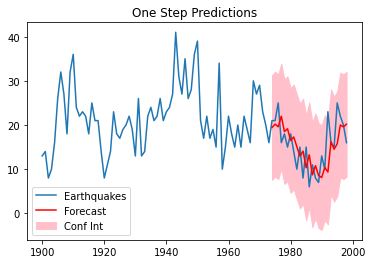

In [8]:
# Plot the observed Data
plt.plot(earthquake, label='Earthquakes')

# Plot Prediction
plt.plot(mean_forecast.index,
         mean_forecast.values,
         color='red', label='Forecast')

# Shade Uncertainty Area
plt.fill_between(lower_limits.index, 
                 lower_limits, 
                 upper_limits,
                 color='pink',
                 label='Conf Int')
plt.title('One Step Predictions')
plt.legend(loc='lower left')
plt.show()

#### Making Dynamic Predictions
only difference is to set dynamic=True in the get_prediction call

In [9]:
# Instantiate the ARMA(3, 1) model
model = SARIMAX(earthquake, order=(3, 0, 1))
# Fit the model
results = model.fit()
# Forecast the last 25 values
forecast = results.get_prediction(start=-25, dynamic=True)
# Forecast Mean and store as series
mean_forecast = forecast.predicted_mean
# Get the confidence intervals as a dataframe
confidence_intervals = forecast.conf_int()
# Select lower and upper confidence limits
lower_limits = confidence_intervals['lower earthquakes_per_year']
upper_limits = confidence_intervals['upper earthquakes_per_year']

C:\Users\16084\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
C:\Users\16084\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'


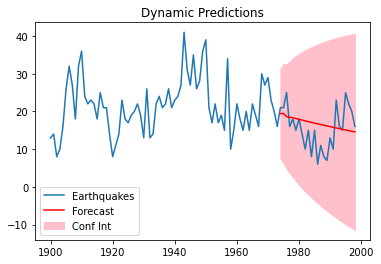

In [10]:
# Plot the observed Data
plt.plot(earthquake, label='Earthquakes')

# Plot Prediction
plt.plot(mean_forecast.index,
         mean_forecast.values,
         color='red', label='Forecast')

# Shade Uncertainty Area
plt.fill_between(lower_limits.index, 
                 lower_limits, 
                 upper_limits,
                 color='pink',
                 label='Conf Int')
plt.title('Dynamic Predictions')
plt.legend(loc='lower left')
plt.show()

### Forecasting out of sample
Use results.get_forecast(), set "step" equal to desired number of predictions

In [11]:
# Instantiate the ARMA(3, 1) model
model = SARIMAX(earthquake, order=(3, 0, 1))
# Fit the model
results = model.fit()
# Forecast the last 25 values
forecast = results.get_forecast(steps=20)
# Forecast Mean and store as series
mean_forecast = forecast.predicted_mean
# Get the confidence intervals as a dataframe
confidence_intervals = forecast.conf_int()
# Select lower and upper confidence limits
lower_limits = confidence_intervals['lower earthquakes_per_year']
upper_limits = confidence_intervals['upper earthquakes_per_year']

C:\Users\16084\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
C:\Users\16084\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'


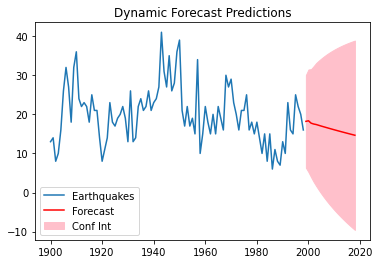

In [12]:
# Plot the observed Data
plt.plot(earthquake, label='Earthquakes')

# Plot Prediction
plt.plot(mean_forecast.index,
         mean_forecast.values,
         color='red', label='Forecast')

# Shade Uncertainty Area
plt.fill_between(lower_limits.index, 
                 lower_limits, 
                 upper_limits,
                 color='pink',
                 label='Conf Int')
plt.title('Dynamic Forecast Predictions')
plt.legend(loc='lower left')
plt.show()

## Intro to ARIMA Models
- Reminder that ARMA models do not  work on non-stationary data. Often we need to transform the data by taking the difference in order to make it stationary. We can then model it using time series
- However, when taking the difference and modeling it, the resulting prediction is the difference, not the actual time series value we want.
- Steps for prediction:
    - take the difference of time series data
    - fit an ARMA model
    - convert predicted differences back to normal values
    - integrate the forecast


## ARIMA - Autoregressive Integrated Moving Average
- Does the steps described above for us
- Steps to implement
    - from statsmodels.tsa.statespace.sarimax import SARIMAX
    - model = SARIMAX(df, order=(p, d, q))
        - p = AR order/number of lags
        - d = order of differencing
        - q = MA order/number of lags
- Important only to diffence data until it is stationary. This can be tested before fitting the model using the adfuller test

### Predicting actual, not difference, with ARMA

In [13]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX

amazon = pd.read_csv('amazon_close.csv', index_col='date', parse_dates=True)

# Take the first difference of the data
amazon_diff = amazon.diff().dropna()

# Create ARMA(2,2) model
arma = SARIMAX(amazon_diff, order=(2,0,2))

# Fit model
arma_results = arma.fit()

# Make arma forecast of next 10 differences
arma_diff_forecast = arma_results.get_forecast(steps=10).predicted_mean

# Integrate the difference forecast
arma_int_forecast = np.cumsum(arma_diff_forecast)

# Make absolute value forecast
arma_value_forecast = arma_int_forecast + amazon.iloc[-1,0]

# Print forecast
print(arma_value_forecast)

C:\Users\16084\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\16084\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:220: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it is not'
C:\Users\16084\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\16084\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:220: ValueWarning: A date index has been provided, but it is not monotonic and so will be i

1258    359.999098
1259    360.587501
1260    359.810700
1261    360.402814
1262    359.698007
1263    360.280214
1264    359.632751
1265    360.197134
1266    359.597108
1267    360.139314
dtype: float64


C:\Users\16084\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:580: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


### Using ARIMA model

In [14]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX

amazon = pd.read_csv('amazon_close.csv', index_col='date', parse_dates=True)

# Create ARIMA(2,1,2) model
arima = SARIMAX(amazon, order=(2, 1, 2))

# Fit ARIMA model
arima_results = arima.fit()

# Make ARIMA forecast of next 10 values
arima_value_forecast2 = arima_results.get_forecast(steps=10).predicted_mean

# Print forecast
print(arima_value_forecast2)

C:\Users\16084\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\16084\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:220: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it is not'
C:\Users\16084\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\16084\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:220: ValueWarning: A date index has been provided, but it is not monotonic and so will be i

1259    359.999315
1260    360.587774
1261    359.811135
1262    360.403261
1263    359.698583
1264    360.280772
1265    359.633416
1266    360.197763
1267    359.597830
1268    360.139988
dtype: float64


C:\Users\16084\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:580: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


# Ch. 3 Intro to ACF and PACF
## How to identify the correct model order for best model/results?
- ACF - Autocorrelation Function
    - correlation between the time series and the same time series lagged by n number of steps
    
- PACF - Partial Autocorrelation Function
    - correlation between a time series and the lagged version of itself after we subtract the effect of correlation at smaller lags
    - correlation associated with JUST that lag

<b>Using ACF and PCAF to choose model order</b>
- If the ACF amplitude tails off while the PACF amplitude cuts off after lag p, we have an AR(p) model
- If the ACF amplitude cuts off after lag q while the PACF amplitude tails off, we have an MA(q) model
- If both the ACF and PACF amplitude tails off, we have an ARMA model and we can't diduce model orders from the plot

Over/Under differencing and ACP and PACF
- If ACF values stay high and tail off slowly, this is a sign the data is non-stationary and needs to be differenced
- If auto-correlation at lag-1 is very negative, this is a sign we have taken the difference too many times

##### Plotting ACF and PACF together

In [15]:
# imports to plot ACF and PACF
#from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Create Figure
# fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,8))

# make ACF plot
# plot_acf(df, lags=10, zero=False, ax=ax1)

# make PACF plot
# plot_pacf(df, lags=10, zero=False, ax=ax2)

# plt.show()

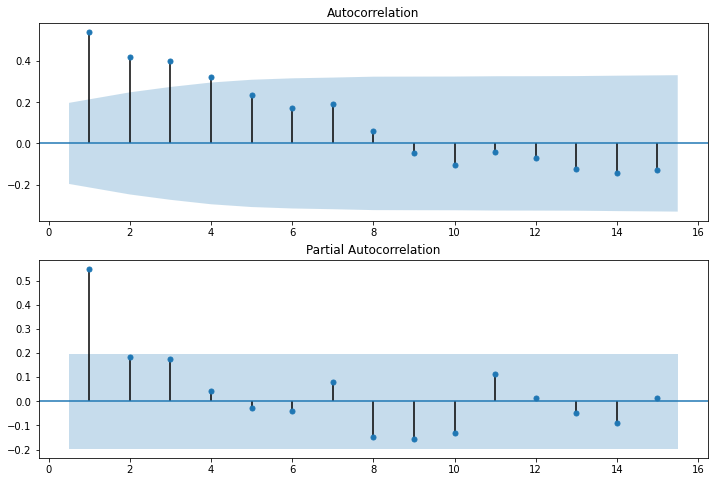

In [16]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Create figure
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8))

# Plot ACF and PACF
plot_acf(earthquake, lags=15, zero=False, ax=ax1)
plot_pacf(earthquake, lags=15, zero=False, ax=ax2)

# Show plot
plt.show()

based on above, the model order should be AR(1) since the PACF cuts off after 1 while the ACF continues to tail off

In [17]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Instantiate model
model = SARIMAX(earthquake, order=(1, 0, 0))

# Train model
results = model.fit()

C:\Users\16084\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
C:\Users\16084\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'


## AIC and BIC
Both scores are lower with better performing models. Both models add a penalization factor to the score for models that are too complex in order to help reduce chance of overfitting. However, BIC favors simpler models more than AIC. Both models are usualy about the same score. But when they are differnt we have to decide: 
- AIC is better with choosing better predicting models
- BIC is better at choosing better explanatory models

#### Looping through ARMA models to find best AIC and BIC scores

In [18]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Create empty list to store search results
order_aic_bic=[]

# Loop over p values from 0-2
for p in range(0,3):
  # Loop over q values from 0-2
    for q in range(0,3):
        try:
            # create and fit ARMA(p,q) model
            model = SARIMAX(earthquake, order=(p,0,q))
            results = model.fit()

            # Append order and results tuple
            order_aic_bic.append((p, q, results.aic, results.bic))
        except:
            # Append order and results tuple
            order_aic_bic.append((p, q, None, None))

# Construct DataFrame from order_aic_bic
order_df = pd.DataFrame(order_aic_bic, 
                        columns=['p', 'q','AIC','BIC'])

# Print order_df in order of increasing AIC
print(order_df.sort_values('AIC'))

# Print order_df in order of increasing BIC
print(order_df.sort_values('BIC'))

C:\Users\16084\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
C:\Users\16084\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
C:\Users\16084\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
C:\Users\16084\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
C:\Users\16084\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No f

   p  q         AIC         BIC
4  1  1  647.132300  654.917660
5  1  2  648.738566  659.119046
7  2  1  648.842840  659.223319
8  2  2  648.850644  661.826244
6  2  0  656.028374  663.813734
3  1  0  666.645526  671.835765
2  0  2  761.067479  768.852838
1  0  1  799.674173  804.864412
0  0  0  888.429772  891.024892
   p  q         AIC         BIC
4  1  1  647.132300  654.917660
5  1  2  648.738566  659.119046
7  2  1  648.842840  659.223319
8  2  2  648.850644  661.826244
6  2  0  656.028374  663.813734
3  1  0  666.645526  671.835765
2  0  2  761.067479  768.852838
1  0  1  799.674173  804.864412
0  0  0  888.429772  891.024892


C:\Users\16084\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
C:\Users\16084\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\16084\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
C:\Users\16084\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'


## Model Diagnostics
### Residuals Analysis
can be accessed from results.residuals after fitting model
- Mean Absolute Error: How far are the predictions from the real values?
    - mae = np.mean(np.abs(residuals))
    
- You can create diagnostic plots to help evaluate
    - results.plot_diagnostics()
    - plt.show()
- Residual plot should appear to have no pattern
- histogram should be normal, green and orange line very similar
    - Prob (JB) in the summary table: p-value for null hyp that the residuals are normally distributed
- QQ plot should have points on or very near red line, except near ends
    - Prob (Q) in the summary table: p-value for null hyp that the residuals are uncorrelated
- Correlogram should have no points outside the interval range past lag 1

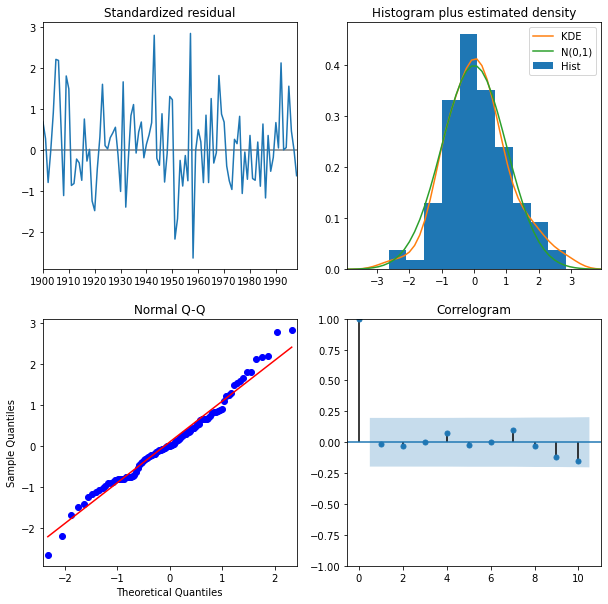

In [19]:
results.plot_diagnostics(figsize=(10,10))
plt.show()

C:\Users\16084\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
C:\Users\16084\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'


MAE:  4.755622568072753


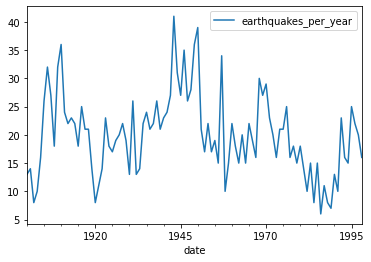

In [20]:
# Fit model
model = SARIMAX(earthquake, order=(1,0,1))
results = model.fit()

# Calculate the mean absolute error from residuals
mae = np.mean(np.abs(results.resid))

# Print mean absolute error
print('MAE: ',mae)

# Make plot of time series for comparison
earthquake.plot()
plt.show()

Great! Your mean error is about 4-5 earthquakes per year. You have plotted the time series so that you can see how the MAE compares to the spread of the time series. Considering that there are about 20 earthquakes per year that is not too bad.

## Box-Jenkins Method
A kind of checklist to go from raw data to a production ready model
- Identification
    - Explore and characterize data to find some form that is appropriate for ARIMA modeling
        - Is the time series stationary?
        - What differencing will make it stationary?
        - What transforms will make it stationary?
        - What values of p and q are most promising?
    - Tools
        - Plot the time series
        - Use Augmented Dicky-Fuller test
        - Use transform and/or differencing
        - Plot ACF and PACF to identify promising model orders
- Estimation
    - Use data to train model coefficients
    - Done using the model.fit() method
    - Choose between models using AIC and BIC candidates
- Model Diagnostics
    - Evaluate quality of the best fitting model
        - Are the residuals correlated?
        - Are the residuals normally distributed?
    - Using plot_diagnostics() and summary()
- Is the model good enough? or do we need to rework it?
    - If residuals are not okay, go back to identification and adjust the data/model building choices
    - If residuals are good, then we can forecast with results.get_forecast()


#### Identification

In [21]:
import pandas as pd

eq = pd.read_csv('earthquakes.csv', index_col='date').drop('Year', axis=1)

eq.index = pd.DatetimeIndex(eq.index, freq='infer')

eq.rename(columns={'earthquakes_per_year':'quakes'}, inplace=True)

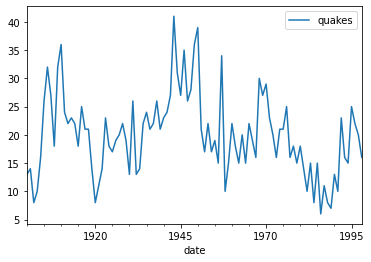

Test Statistic:  -3.183192251191782
p-value:  0.02097842525600371


In [22]:
# Import augmented dicky-fuller test function
from statsmodels.tsa.stattools import adfuller

# Plot time series
eq.plot()
plt.show()

# Run Dicky-Fuller test
result = adfuller(eq['quakes'])

# Print test statistic
print('Test Statistic: ',result[0])

# Print p-value
print('p-value: ',result[1])

Appears to be stationary data based on plot and adfuller results

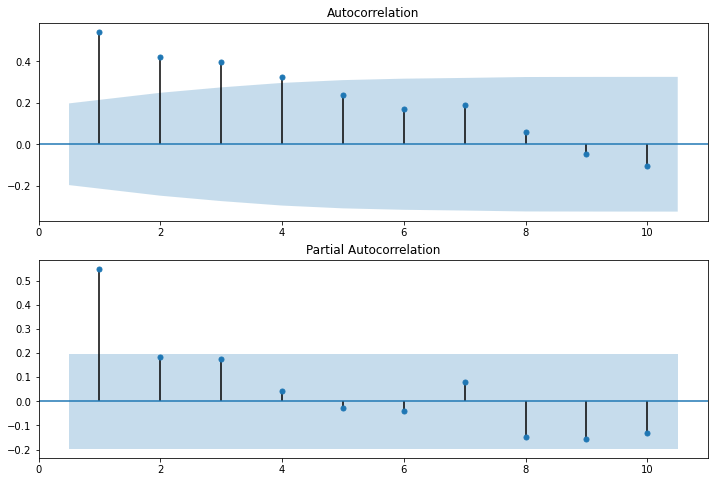

In [23]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Create figure
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8))
 
# Plot the ACF of savings on ax1
plot_acf(eq, lags=10, zero=False, ax=ax1)

# Plot the PACF of savings on ax2
plot_pacf(eq, lags=10, zero=False, ax=ax2)

plt.show()

This model could be an AR(1) or an ARMA(p,q)

#### Explanation

In [24]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Create list to store results
order_aic_bic=[]

# Loop over p values from 0-3
for p in range(4):
  
  # Loop over q values from 0-3
    for q in range(4):
        try:
            # Create and fit ARMA(p,q) model
            model = SARIMAX(eq, order=(p,0,q))
            results = model.fit()

            # Append order and results tuple
            order_aic_bic.append((p, q, results.aic, results.bic))
        
        except:
            order_aic_bic.append((p, q, None, None))
            
# Construct DataFrame from order_aic_bic
order_df = pd.DataFrame(order_aic_bic, columns=['p', 'q','AIC','BIC'])

C:\Users\16084\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\16084\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


In [25]:
# Print order_df in order of increasing AIC
print(order_df.sort_values('AIC').head())

# Print order_df in order of increasing BIC
print(order_df.sort_values('BIC').head())

    p  q         AIC         BIC
5   1  1  647.132300  654.917660
6   1  2  648.738566  659.119046
9   2  1  648.842840  659.223319
10  2  2  648.850644  661.826244
12  3  0  649.748166  660.128646
    p  q         AIC         BIC
5   1  1  647.132300  654.917660
6   1  2  648.738566  659.119046
9   2  1  648.842840  659.223319
12  3  0  649.748166  660.128646
10  2  2  648.850644  661.826244


We will choose the ARMA(1, 1) order since it has the best score for both AIC and BIC

#### Diagnostics

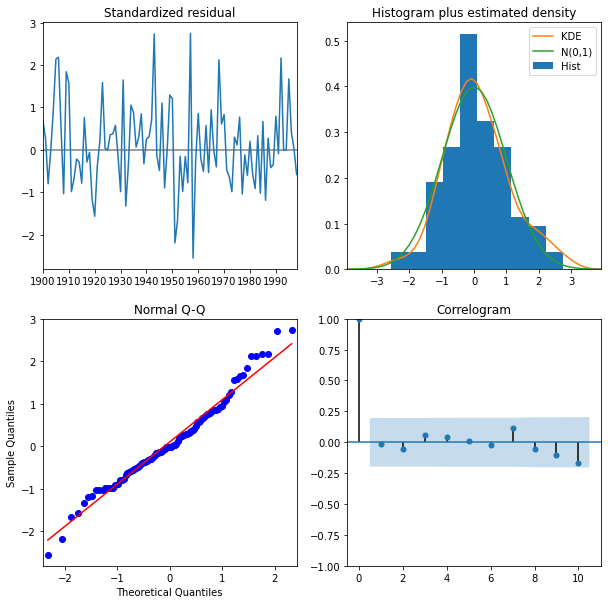

                               SARIMAX Results                                
Dep. Variable:                 quakes   No. Observations:                   99
Model:               SARIMAX(1, 0, 2)   Log Likelihood                -320.369
Date:                Wed, 21 Apr 2021   AIC                            648.739
Time:                        19:59:20   BIC                            659.119
Sample:                    01-01-1900   HQIC                           652.939
                         - 01-01-1998                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9906      0.013     75.384      0.000       0.965       1.016
ma.L1         -0.5106      0.095     -5.401      0.000      -0.696      -0.325
ma.L2         -0.0708      0.094     -0.754      0.4

In [26]:
# Create and fit model
model = SARIMAX(eq, order=(1, 0, 2))
results = model.fit()

# Create the 4 diagostics plots
results.plot_diagnostics(figsize=(10,10))
plt.show()

# Print summary
print(results.summary())

#### Using the final model to forecast

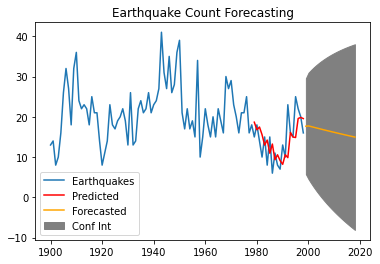

In [27]:
# Predict the last 25 values
predictions = results.get_prediction(start=-20)
# Predict Mean and store as series
mean_predictions = predictions.predicted_mean

#Forecast the next 20 Values
forecast = results.get_forecast(steps=20)
# Forecast Mean and store as series
mean_forecast = forecast.predicted_mean
# Get the confidence intervals of forecast as a dataframe
confidence_intervals = forecast.conf_int()

# Select lower and upper confidence limits
lower_limits = confidence_intervals['lower quakes']
upper_limits = confidence_intervals['upper quakes']

# Plot the observed Data
plt.plot(eq, label='Earthquakes')

# Plot Prediction
plt.plot(mean_predictions.index, mean_predictions.values, 
         color='red', label='Predicted')

# Plot Forecast
plt.plot(mean_forecast.index, mean_forecast.values, 
         color='orange', label='Forecasted')

# Shade Uncertainty Area
plt.fill_between(lower_limits.index, lower_limits, upper_limits, 
                 color='Grey', label='Conf Int')

plt.title('Earthquake Count Forecasting')
plt.legend(loc='lower left')
plt.show()

# Ch. 4 Seasonal ARIMA Models
- Seasonal time series has predictable and repeated patterns
- Called seasonal, but can be any period of time that repeats (weekly, monthly, quarterly, annually)

## Seasonal Decomposition
- Time Series = Trend + Seasonal Components + Residual
- can use statsmodels.tsa.season seasonal_decompose to seperate any time series into these three components

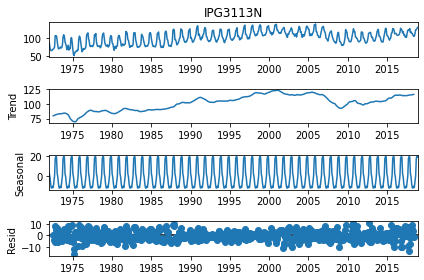

In [28]:
# Load in the time series
candy = pd.read_csv('candy_production.csv', index_col='date', parse_dates=True)

# Imports
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose Data, period is the number of datapoints in each repeated cycle. 
decomp_results = seasonal_decompose(candy['IPG3113N'], period=12)

# Plot the decomposed data
decomp_results.plot()
plt.show()

### Finding seasonality with ACF
To decompose data you need to know how often cycles repeat. If unknown, you can use the ACF to determine. look for lags near 1.0 to determine the number of points in the cycle

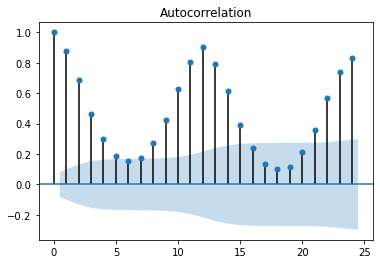

In [29]:
plot_acf(candy, lags=24)
plt.show()

## SARIMA Model (Seasonal ARIMA)
- SARIMA is like fitting two model at once: one to the seasonal part, and one to the non-seasonal part
- Will have two sets of orders
    - Non-seasonal (p, d, q)
        - p: AR Order
        - d: differencing order
        - q: MA order
    - Non-seasonal (P, D, Q, S)
        - P: Seasonal AR Order
        - D: Seasonal differencing order
        - Q: Seasonal MA order
        - S: number of time steps per cycle

In [30]:
# Imports
# from statsmodels.tsa.statespace.sarimax import SARIMAX

# Instantiate the model
# model = SARIMAX(df, order=(p, d, q), seasonal_order=(P, D, Q, S))

# Fit the model
# results = model.fit()

## Finding Seasonal Orders
Above we saw how to find the season period, S, using ACF

#### Seasonal Differencing
- subtract the time series value of one season, or period, ago
- df_diff = df.diff(S)

### Finding P and Q
- plot the ACF and PACF of the seasonal difference time series

### Searching over Model Orders
- auto_arima from pmdarima package loops over model orders automatically returns a results object with the best model find. This results object looks almost exactly like the sarimax summary and has plot_diagnostics as well
- Parameters
    - df: data. This is the only required parameter
    - d: non-seasonal difference order
    - start_p: initial guess for p
    - start-q: initial guess for q
    - max_p: max value of p to test
    - max_q: max value of q to test
    - seasonal: set to True if the time series is seasonal
    - m: the length of seasonal Period
    - D: seasonal difference order
    - start_P: initial guess for P
    - start-Q: initial guess for Q
    - max_P: max value of P to test
    - max_Q: max value of Q to test
    - information_criterion: choose best model based on 'aic' or 'bic'
    - trace: if True, prints aic and bic for each model it fits
    - error_action: set to 'ignore' to ignore orders that don't work and would cause an error
    - stepwise: if True, applies intelligent search rather than searching each possible model

### Saving Model Objects
Once a model is found using auto_arima, you may want to save it to be able to load later
- use joblib dump and load to save and load a model object (code below)


In [31]:
#import pmdarima as pm
#results = pm.auto_arima(df)

# Import joblib

# Select a file path
# filepath ='...'

# Save model to filepath
# joblib.dump(model_results_object, filepath)

# Loading a model from filepath
# filepath ='...'
#model_results_object = joblib.load(filepath)

## SARIMA and Box-Jenkins
- Identification
    - Explore and characterize data to find some form that is appropriate for SARIMA modeling
        - Determine if time series is seasonal
            - Find seasonal Period
        - Is the time series stationary?
        - What differencing will make it stationary?
            - Seasonal and non-seasonal differencing
            - recommended to not use more than one order of seasonal differencing (D) and to not use more than 2 orders of differencing in total (d + D)
        - What transforms will make it stationary?
        - What values of p and q are most promising?
        
    - Tools
        - Plot the time series
        - Use Augmented Dicky-Fuller test
        - Use transform and/or differencing
        - Plot ACF and PACF to identify promising model orders
- Estimation
    - Use data to train model coefficients
    - Done using the model.fit() method
    - Choose between models using AIC and BIC candidates
- Model Diagnostics
    - Evaluate quality of the best fitting model
        - Are the residuals correlated?
        - Are the residuals normally distributed?
    - Using plot_diagnostics() and summary()
- Is the model good enough? or do we need to rework it?
    - If residuals are not okay, go back to identification and adjust the data/model building choices
    - If residuals are good, then we can forecast with results.get_forecast()

### CO2 Time Series

In [32]:
co2 = pd.read_csv('co2.csv', index_col='date', parse_dates=True)
co2.index = pd.DatetimeIndex(co2.index, freq='infer')

In [33]:
# Import model class
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Create model object
model = SARIMAX(co2, 
                order=(1,1,1), 
                seasonal_order=(0,1,1,12), 
                trend='c')
# Fit model
results = model.fit()
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                            CO2_ppm   No. Observations:                  727
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -179.718
Date:                            Wed, 21 Apr 2021   AIC                            369.437
Time:                                    19:59:28   BIC                            392.291
Sample:                                03-01-1958   HQIC                           378.263
                                     - 09-01-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0017      0.001      2.807      0.005       0.001       0.003
ar.L1          0.2413      0.078   

<function matplotlib.pyplot.show(*args, **kw)>

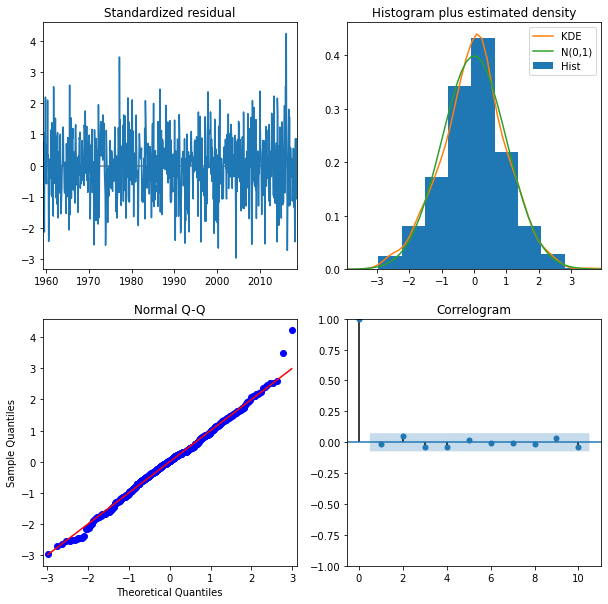

In [34]:
results.plot_diagnostics(figsize=(10,10))
plt.show

#### Forecast CO2 emissions up to year 2030

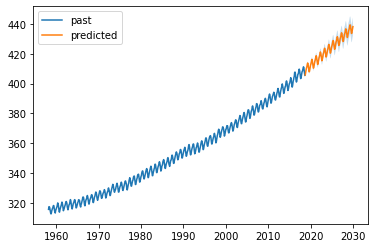

In [38]:
# Create forecast object
forecast_object = results.get_forecast(steps=136)

# Extract predicted mean attribute
mean = forecast_object.predicted_mean

# Calculate the confidence intervals
conf_int = forecast_object.conf_int()

# Extract the forecast dates
dates = mean.index

plt.figure()

# Plot past CO2 levels
plt.plot(co2.index, co2, label='past')

# Plot the prediction means as line
plt.plot(mean.index, mean, label='predicted')

# Shade between the confidence intervals
plt.fill_between(dates, conf_int.iloc[:,0], conf_int.iloc[:,1], alpha=0.25)

# Plot legend and show figure
plt.legend()
plt.show()

In [36]:
# Print last predicted mean
print('Forecasted CO2 level in 2030: ',mean[-1],'\n')

# Print last confidence interval
print('95% confidence range:\n',conf_int.iloc[-1])

Forecasted CO2 level in 2030:  438.1961399083201 

95% confidence range:
 lower CO2_ppm    432.113415
upper CO2_ppm    444.278865
Name: 2030-01-01 00:00:00, dtype: float64
